# Practice PS06: Recommendations engines (interactions-based)

For this assignment we will build and apply an item-based and model-based collaborative filtering recommenders for movies. 

Author: <font color="blue">Judith Camacho</font>

E-mail: <font color="blue">judith.camacho01@estudiant.upf.edu</font>

Date: <font color="blue">05/11/2020</font>

# 0. The MovieLens-1M dataset

We will use the same dataset as in PS05, the [MovieLens DataSet](https://grouplens.org/datasets/movielens/1m/). This dataset was released in 2003 and most of the movies on it are from the 1980s and 1990s.

For details on this, look at the PS05 practice session. Remember the data is contained in three files: `ratings.dat`, `users.dat`, and `movies.dat`.

**RATINGS** are contained in `ratings.dat` in the following format: `UserID::MovieID::Rating::Timestamp`

**USERS** are described in `users.dat` in the following format: `UserID::Gender::Age::Occupation::Zip-code`

**MOVIES** are described in `movies.dat` in the following format: `MovieID::Title::Genres`
    
<font size="-1" color="gray">(Remove this cell when delivering.)</font>

# 0.1. Load the input files

In [61]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from math import*
from scipy.sparse.linalg import svds
from sklearn.metrics.pairwise import linear_kernel

In [62]:
FILENAME_RATINGS = "ratings.dat"
FILENAME_USERS = "users.dat"
FILENAME_MOVIES = "movies.dat"

In [63]:
ratings_raw = pd.read_csv(FILENAME_RATINGS, 
                    sep='::', 
                    encoding='latin-1',
                    engine='python',
                    names=['user_id', 'movie_id', 'rating', 'timestamp'])

users = pd.read_csv(FILENAME_USERS, 
                    sep='::', 
                    engine='python', 
                    encoding='latin-1',
                    names=['user_id', 'gender', 'age', 'occupation', 'zipcode'])
_ = users.set_index('user_id')

movies = pd.read_csv(FILENAME_MOVIES, 
                    sep='::', 
                    engine='python', 
                    encoding='latin-1',
                    names=['movie_id', 'title', 'genres'])
_ = movies.set_index('movie_id')

# 0.2. Merge the data into a single dataframe

In [64]:
ratings = pd.merge(ratings_raw, users, 'inner', on='user_id')
ratings = pd.merge(ratings, movies, 'inner', on='movie_id')

In [65]:
def find_movies(keyword, df):
    new_df = df[df["title"].str.contains(keyword)].filter(["movie_id", "title"], axis=1).drop_duplicates()
    
    print(new_df.to_string(index=False))

# 1. Exploratory Data Analysis

First we continue exploring this dataset to learn more about it. This complements the data exploration tasks we did in the previous practice.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

## 1.1. Unique registers

Count the number of unique users and unique movies in the `ratings` variable. Use [unique()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.unique.html)

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [66]:
ratings.user_id.unique().size

6040

There are 6040 unique users.

In [67]:
ratings.movie_id.unique().size

3706

There are 3706 unique movies.

## 1.2. Age differences in ratings

Now let's look at whether people of different age rate movies differently. In this dataset the `age` column is actually a range:

	*  1:  "Under 18"
	* 18:  "18-24"
	* 25:  "25-34"
	* 35:  "35-44"
	* 45:  "45-49"
	* 50:  "50-55"
	* 56:  "56+"

Create a [boxplot](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.boxplot.html) in which in the x axis you have the age buckets and in the y axis the distribution of ratings. 

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

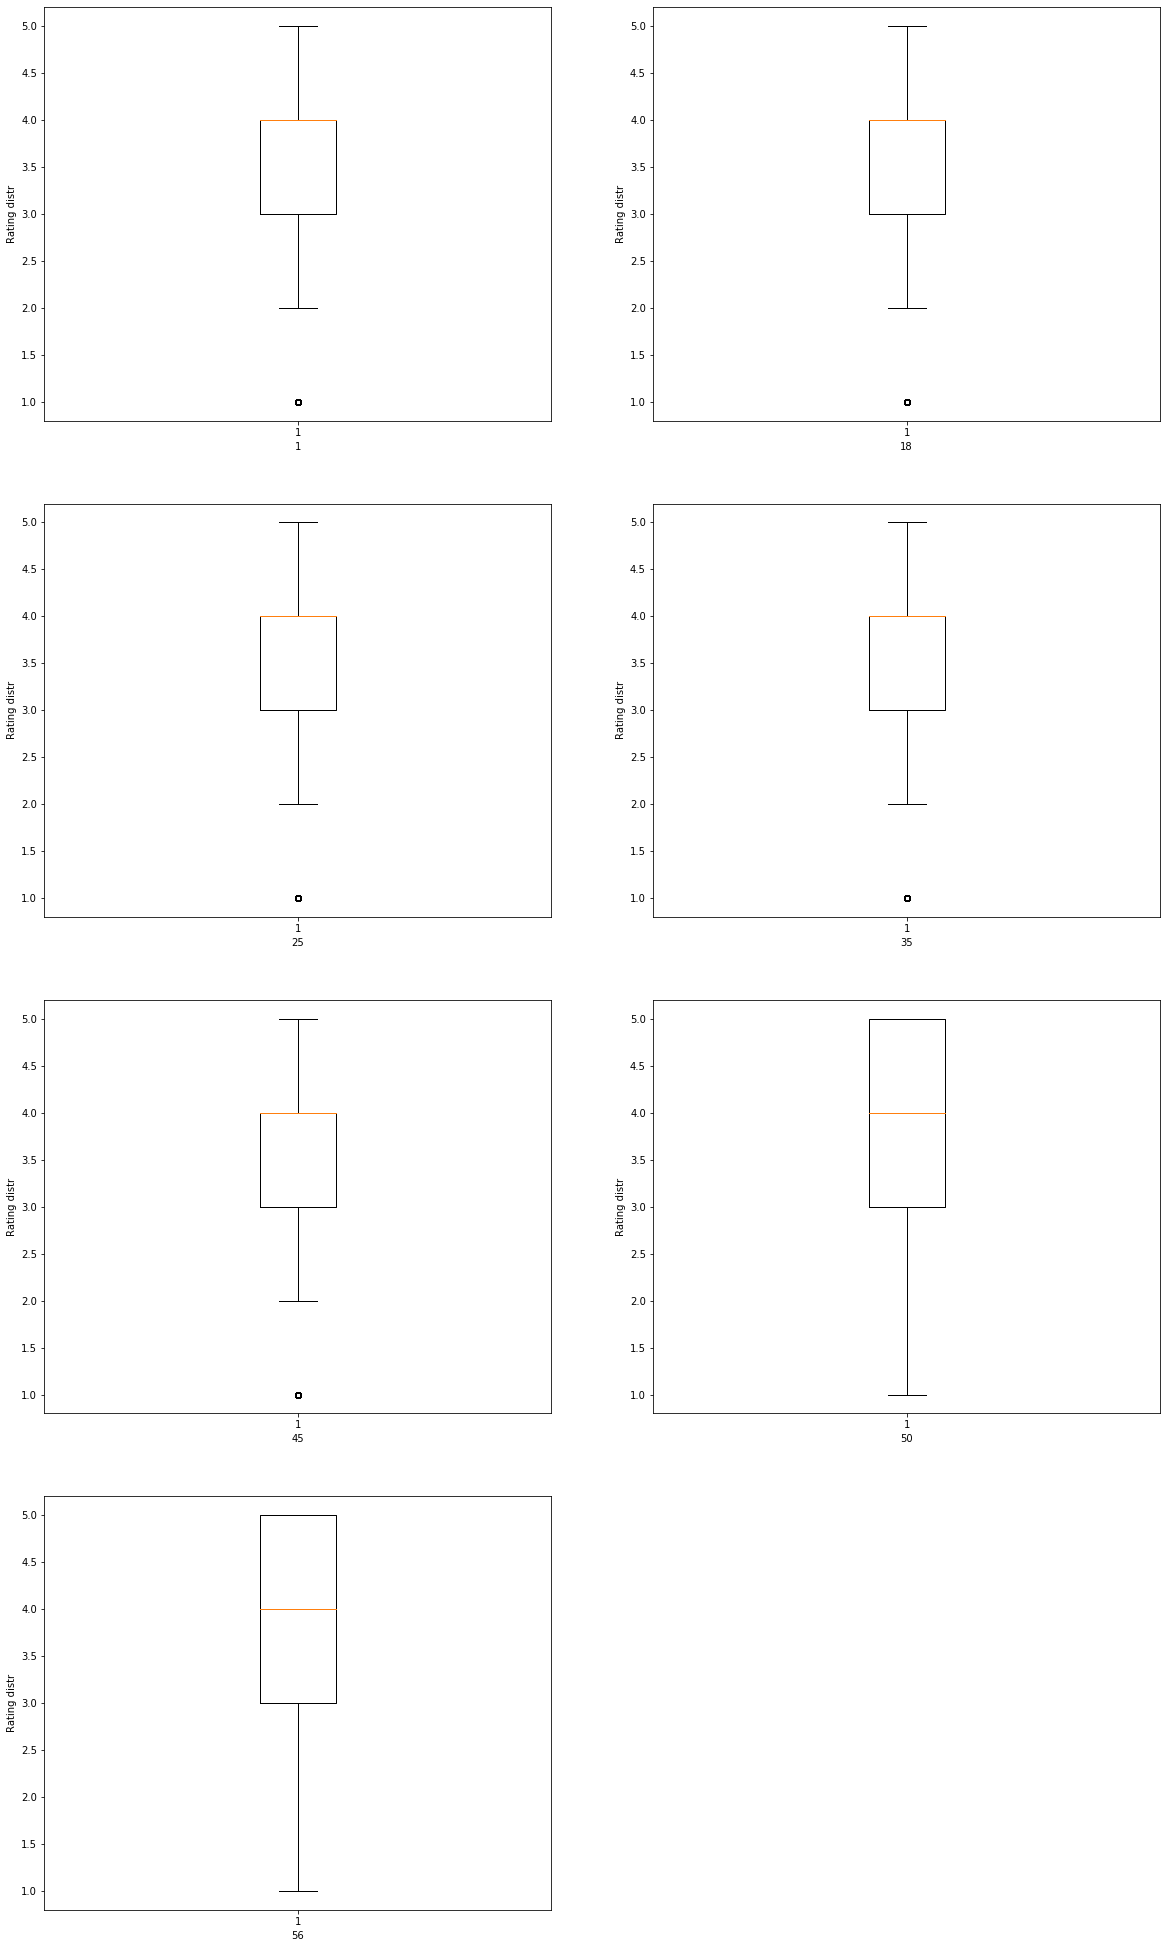

In [68]:
# create 1 boxblot for each age group
i = 421 
ages = sorted(ratings.age.unique().tolist())
plt.figure(figsize = (20, 35))
for c in ages:
    plt.subplot(i)
    plt.boxplot(ratings["rating"][ratings["age"]==c])
    plt.xlabel(c) #x axis is the age 
    plt.ylabel('Rating distr') #y axis will is the ratings distribution
    i+=1


We can see that the median for ratings is in 4 for all the group ages; also, older people give higher ratings (Percentile of 75% is at 5). 


# 2. Item-based Collaborative Filtering

The two main types of interactions-based recommender system, also known as *collaborative filtering* algorithms are:

1. **User-based Collaborative Filtering**: To recommend items for user A, we first look at other users B1, B2, ..., Bk with a similar behavior to A, and aggregate their preferences. For instance, if all Bi like a movie that A has not watched, it would be a good candidate to be recommended. 


2. **Item-based Collaborative Filtering**: To recommend items for user A, we first look at all the items I1, I2, ..., Ik that the user A has consumed, and find items that elicit similar ratings from other users. For instnce, an item that is rated positively by the same users that rate positively the Ii items, and negatively by the same users that rate negatively the Ii items, would be a good candidate to be recommended.

In both cases, a similarity matrix needs to be built. For user-based, the **user-similarity matrix** will consist of some **distance metrics** that measure the similarity between any two pairs of users. For item-based, the **matrix** will measure the similarity between any two pairs of items.

As we already know, there are several metrics strategy for measure the "similarity" of two items. Some of the most used metrics are Jaccard, Cosine and Pearson. Meanwhile, Jaccard similarity is based on the number of users which have rated item A and B divided by the number of users who have rated either A or B (very useful for those use cases where there is not a numeric rating but just a boolean value like a product being bought), in Pearson and Cosine similarities we measure the similarity between two vectors.

For the purpose of this assignment, we will use **Pearson Similarity** and we will implement a **Item-based Collaborative filtering**.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

## 2.1. Data pre-processing

Firstly, create a new dataset "rated_movies" that [merges](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html) `ratings_raw` and `movies` on the **movie_id** variable. [Drop](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html) from this the columns we do not need: *genres* and *timestamp*. Print the first 5 rows of this new dataframe.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [69]:
rated_movies = pd.merge(movies, ratings_raw, 'inner', on='movie_id')
rated_movies = rated_movies.drop(["genres", "timestamp"], axis=1)


In [70]:
rated_movies.head(5)

,movie_id,title,user_id,rating
0,1,Toy Story (1995),1,5
1,1,Toy Story (1995),6,4
2,1,Toy Story (1995),8,4
3,1,Toy Story (1995),9,5
4,1,Toy Story (1995),10,5


Now, using the rated_movies dataframe, create a new dataframe named `ratings_summary` containing the following columns:

* movie_id
* title
* ratings_mean (average rating)
* ratings_count (number of people who have rated this movie)

You can use the following operations:

* Initialize `ratings_summary` to be only the movie_id and title of all movies in `rated_movies`
   * To group dataframe `df` by column `a` and keep only one unique row per value of `a`, use: `df.groupby('a').first()`
* Compute two series: `ratings_mean` and `ratings_count`:
   * To obtain a series with the average of column `a` for each distinct value of column `b` in dataframe `df`, use: `df.groupby(b)['a'].mean()`
   * To obtain a series with the count of column `a` for each distinct value of column `b` in dataframe `df`, use: `df.groupby(b)['a'].count()`
* Add these series to the `ratings_summary`
   * To add a series `s` with column name `a` to dataframe `df`, use: `df['a'] = s`
    
<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [71]:
ratings_summary = rated_movies.groupby(["movie_id", "title"]).rating.agg(["mean", "count"]).reset_index()
ratings_summary.rename({"mean":"ratings_mean", "count":"ratings_count"},axis=1, inplace=True)

In [74]:
ratings_summary.sort_values(["ratings_count"], ascending=False).head(10)

,movie_id,title,ratings_mean,ratings_count
2651,2858,American Beauty (1999),4.317386,3428
253,260,Star Wars: Episode IV - A New Hope (1977),4.453694,2991
1106,1196,Star Wars: Episode V - The Empire Strikes Back...,4.292977,2990
1120,1210,Star Wars: Episode VI - Return of the Jedi (1983),4.022893,2883
466,480,Jurassic Park (1993),3.763847,2672
1848,2028,Saving Private Ryan (1998),4.337354,2653
575,589,Terminator 2: Judgment Day (1991),4.058513,2649
2374,2571,"Matrix, The (1999)",4.315830,2590
1178,1270,Back to the Future (1985),3.990321,2583
579,593,"Silence of the Lambs, The (1991)",4.351823,2578


The movies on this list are very known movies, hence many people have rated them. They're ratings are between 3.9 and 4.5 that is because maybe for most of the people they are good movies so they rate them high.

## 2.2. Compute user-movie matrix

Before calculating the **similarity matrix**, we create a table where columns are movies and rows are users, and each movie-user cell contains the score of that user for that movie.

We will use the [pivot_table](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.pivot_table.html) function of Pandas. If you have a dataframe D containing:

```
U V W
1 a 3.0
1 b 2.0
2 a 1.0
2 c 4.0
```

Calling `D.pivot_table(index='U', columns='V', values='W')` will create the following:

```
V  a   b   c
U
1 3.0 2.0 NaN
2 1.0 NaN 4.0
```

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [75]:
user_movie = rated_movies.pivot_table(index="user_id", columns="movie_id", values="rating")

In [76]:
user_movie

movie_id,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,NaN,NaN,NaN,2.0,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6038,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


There are so many NaNs because the columns are all the unique movies, and people have watch only a small amout of them.

# 2.3. Explore some correlations in the user-movie matrix

Now let us explore whether correlations in this matrix make sense.

Locate the movie_id for *[The Godfather (1972)](https://en.wikipedia.org/wiki/The_Godfather)*, *[The Godfather Part II (1974)](https://en.wikipedia.org/wiki/The_Godfather_Part_II)*, *[Saving Private Ryan (1998)](https://en.wikipedia.org/wiki/Saving_Private_Ryan)* and *[Dirty Dancing (1987)](https://en.wikipedia.org/wiki/Dirty_Dancing)* using the `find_movies` function you defined above.

Now, obtain the ratings for each of these movies: `user_movie[movie_id].dropna()`. You will obtain a series for each movie.

Now, consolidate these four series into a single dataframe: `ratings4 = pd.concat([s1, s2, s3, s4], axis=1)`

Drop from `ratings4` all rows containing a *NaN*. This will keep only users that have rated the 4 movies.

Display the resulting table.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [77]:
# id's of the movies, i'll read them by hand
find_movies("Godfather", movies)
find_movies("Saving Private Ryan", movies)
find_movies("Dirty Dancing", movies)

 movie_id                            title
      858            Godfather, The (1972)
     1221   Godfather: Part II, The (1974)
     2023  Godfather: Part III, The (1990)
 movie_id                       title
     2028  Saving Private Ryan (1998)
 movie_id                 title
     1088  Dirty Dancing (1987)


In [78]:
# ratings for these movies of the users 
s1 = user_movie[858].dropna()
s2 = user_movie[1221].dropna()
s3 = user_movie[2028].dropna()
s4 = user_movie[1088].dropna()
ratings4 = pd.concat([s1, s2, s3, s4], axis=1)

In [79]:
ratings4

,858,1221,2028,1088
user_id,,,,
1,NaN,NaN,5.0,NaN
2,NaN,NaN,4.0,NaN
4,NaN,NaN,5.0,NaN
5,NaN,NaN,2.0,NaN
6,NaN,NaN,NaN,5.0
...,...,...,...,...
6033,4.0,4.0,5.0,NaN
6036,NaN,NaN,5.0,NaN
6037,5.0,5.0,4.0,NaN


This table shows the ratings for the 4 selected movies of each user_id. Users who haven't seen them, have a NaN.

To compute Pearson correlation, we use the [corr](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.corr.html) method.

To compute the correlation between two columns `a`, `b` in dataframe `df`, we use: `df[a].corr(df[b])`.

Compute the correlations between all pairs of columns of the `ratings4` and write your conclusions.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [82]:

# build correlation matrix. Correlation between one col and itself=1. Pearson is the default method
corr_matrix = [
    [1, ratings4[858].corr(ratings4[1221], "pearson"), ratings4[858].corr(ratings4[2028]),ratings4[858].corr(ratings4[1088])],
    [ratings4[1221].corr(ratings4[858]), 1, ratings4[1221].corr(ratings4[2028]),ratings4[1221].corr(ratings4[1088])],
    [ratings4[2028].corr(ratings4[858]), ratings4[2028].corr(ratings4[1221]), 1,ratings4[2028].corr(ratings4[1088])],
    [ratings4[1088].corr(ratings4[858]), ratings4[1088].corr(ratings4[1221]), ratings4[1088].corr(ratings4[2028]), 1]
]


In [83]:
corr_matrix

[[1, 0.714074105262551, 0.20800973032302517, -0.19439141546143127],
 [0.714074105262551, 1, 0.13847105365992826, -0.07031309098585188],
 [0.20800973032302517, 0.1384710536599283, 1, 0.1884930647347916],
 [-0.1943914154614313, -0.07031309098585188, 0.18849306473479163, 1]]

The movies with higher correlation are The Goodfather I and the GoodFather II (0.71). This makes sense because one is the continuation of the other.
The ones less correlated are The Godfather and Dirty Dancing. These two films have nothing in common (opposite genres in fact) so it makes sense.
The other values are pretty low also, that's because they are films that don't have many things in common.

Now let us take one of these movies *[Dirty Dancing (1987)](https://en.wikipedia.org/wiki/Dirty_Dancing)*, a musical romance. Select the column corresponding to this movie in `user_movies` and compute its correlation with all other columns in `user_movies`. This can be done with  [corrwith](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corrwith.html). You might receive a runtime warning on degrees of freedom and/or division by zero, which you can safely ignore.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [84]:
similar_to_dirt=user_movie.corrwith(user_movie[1088]).dropna()
similar_to_dirt

C:\Users\Judith\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
C:\Users\Judith\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


movie_id
1       0.193828
2       0.217617
3       0.188667
4       0.180094
5       0.310525
          ...   
3948    0.118325
3949   -0.020589
3950    0.171421
3951    0.353553
3952    0.236221
Length: 3336, dtype: float64

Next, create a dataframe `corr_with_dirt` by using `similar_to_dirt` and `ratings_summary`. This dataframe should have the following columns:

* corr - the correlation between each movie and the selected movie
* title
* ratings_mean
* ratings_count

To create a dataframe `df` from a series `s`, use: `df = pd.DataFrame(s, columns=['colname'])`. 

Keep only rows in which *ratings_count* > 500, i.e., popular movies. To filter a dataframe `df` and keep only rows having column `c` larger than `x`, use `df[df[c] > x]`.

Display the top 10 rows with the largest correlation. To select the largest `n` rows from dataframe `df` according to column `c`, use `df.sort_values(c, ascending=False).head(n)`. 

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [17]:
'''corr_with_dirt = ratings_summary[["title", "ratings_mean", "ratings_count"]]
corr_with_dirt["corr"] = similar_to_dirt 
corr_with_dirt = corr_with_dirt[corr_with_dirt["ratings_count"]>500]
corr_with_dirt.sort_values(["corr"], ascending=False).head(10)
THIS SOLUTION IS NOT WORKING; I HAVE TO REVISE IT'''

In [86]:
corr_with_dirt = pd.DataFrame(similar_to_dirt, columns=['corr']) #corr column is the correlation between each movie and the selected movie
# we merge corr_wth_dirt and ratings_summary
corr_with_dirt = corr_with_dirt.merge(ratings_summary, on='movie_id') 

# keep only the rows in which ratings_count > 500, which are the most popular movies in the dataset
corr_with_dirt = corr_with_dirt[corr_with_dirt['ratings_count']>100]

# sort by correlation and display TOP10
corr_with_dirt.sort_values('corr', ascending=False).head(10)

,movie_id,corr,title,ratings_mean,ratings_count
908,1088,1.000000,Dirty Dancing (1987),3.311499,687
1399,1681,0.679384,Mortal Kombat: Annihilation (1997),2.179104,134
534,587,0.625280,Ghost (1990),3.496441,1124
2487,2942,0.601556,Flashdance (1983),3.099448,362
14,15,0.589194,Cutthroat Island (1995),2.458904,146
2050,2448,0.587166,Virus (1999),2.349206,189
654,765,0.578943,Jack (1996),2.631579,171
2095,2498,0.578464,My Favorite Martian (1999),2.333333,123
326,358,0.573566,Higher Learning (1995),3.170213,141
2373,2815,0.566352,Iron Eagle (1986),2.594096,271


Of course, the first entry corresponds to Dirty Dancing because it's the movie we are studying, and we know that the correlation between a and a is 1.
The other movies that appear here, are also Musicals, Romances, etc. Hence, people that like one kind of genre, tend to like many mvoies of the same genre.
In summary, the movies in this list have similar thematic and stories.

If you replace the 500 by 200 or 100, you get movies that are apparently less similar to Dirty Dancing. For instance, I haven't seen Virus, but what does a SciFi/terror movie have to do with a romance? I am not that sure that people who like romances also like terror movies...

# 2.4. Implement the item-based recommendations

Now that we believe that this type of correlation sort of makes sense, let us implement the item-based recommender. We need all correlations between columns in `user_movie`. To compute all correlations between columns in a dataframe, use [corr](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html).

This process may take a few minutes. Print the first 5 rows of the resulting matrix when done.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [27]:
item_similarity = user_movie.corr()

In [352]:
item_similarity.head(5)

movie_id,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
movie_id,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.187467,0.160649,0.348759,0.156957,0.051097,0.149536,0.151248,-0.039358,0.143598,...,-0.099845,0.174078,0.146344,0.135146,0.431743,0.139323,0.189518,0.146536,0.324325,0.157996
2,0.187467,1.000000,0.149349,0.057874,0.384293,0.075067,0.251093,0.312949,0.407857,0.254558,...,0.009798,-1.000000,0.276240,0.133538,0.042524,0.216196,0.082241,-0.154672,-0.353553,0.073111
3,0.160649,0.149349,1.000000,0.261800,0.399532,0.156934,0.220211,0.394405,0.151163,0.269250,...,-0.134059,0.239046,-0.361158,0.205521,-0.024042,0.314249,0.026743,0.445399,NaN,0.110024
4,0.348759,0.057874,0.261800,1.000000,0.401954,-0.012096,0.097271,0.074080,-0.681895,0.010868,...,0.589662,NaN,NaN,0.158114,-0.500000,0.209258,-0.434783,0.500000,0.000000,0.154463
5,0.156957,0.384293,0.399532,0.401954,1.000000,0.075755,0.276160,0.589313,0.538139,0.241397,...,-0.533114,0.188982,NaN,0.522037,0.960769,0.416291,-0.133077,0.650000,NaN,-0.033736


Similarities between movies that do not have many ratings in common are unreliable. Fortunately, the `corr` method includes a parameter `min_periods` that establishes a minimum number of elements in common that two columns must have to compute the correlation.

Re-generate item_similarity setting min_periods to 100.

This process will also take a few minutes. Print the first 5 rows of the resulting matrix when done.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [32]:
item_similarity_min_ratings = user_movie.corr(min_periods=100)

In [147]:
item_similarity_min_ratings.head(5)

movie_id,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
movie_id,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.187467,0.160649,0.348759,0.156957,0.051097,0.149536,NaN,NaN,0.143598,...,NaN,NaN,NaN,NaN,NaN,0.139323,0.189518,NaN,NaN,0.157996
2,0.187467,1.000000,0.149349,NaN,0.384293,0.075067,0.251093,NaN,NaN,0.254558,...,NaN,NaN,NaN,NaN,NaN,0.216196,NaN,NaN,NaN,NaN
3,0.160649,0.149349,1.000000,NaN,0.399532,0.156934,0.220211,NaN,NaN,0.269250,...,NaN,NaN,NaN,NaN,NaN,0.314249,NaN,NaN,NaN,NaN
4,0.348759,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.156957,0.384293,0.399532,NaN,1.000000,NaN,0.276160,NaN,NaN,0.241397,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We will need to test our function so let us select a couple of interesting users.

Our first user, `user_id_rom` will be someone who has given the following 3 films a rating of 4.0 or higher:

* movie_id=587: *Ghost (1990)*
* movie_id=1088: *Dirty Dancing (1987)*
* movie_id=3257: *The Bodyguard (1992)* 	

Our second user, `user_id_sci` will be someone who has given the following 3 films a rating of 4.0 or higher:

* movie_id=1214: *Alien (1979)*
* movie_id=3527: *Predator (1987)*
* movie_id=260: *Star Wars (1977)*

To filter a dataframe by multiple conditions you can use, e.g., `df[(a > 1) & (b > 2)]`. 

**Important**: these particular users have watched lots of movies, so we cannot tell for sure they have only these interests.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [87]:
# filter users that have seen the 3 movies
user_id_rom = user_movie[(user_movie[587]>4) & (user_movie[1088]>4) & (user_movie[3257]>4)].index[0]
user_id_sci = user_movie[(user_movie[1214]>4) & (user_movie[3527]>4) & (user_movie[260]>4)].index[0]

In [90]:
# cell used to see what the variables store
user_id_rom

4086

We will need some auxiliary functions that are provided below. You can leave as-is.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [91]:
# Gets a list of watched movies for a user_id
def get_watched_movies(user_id, user_movie):
    return list(user_movie.loc[user_id].dropna().index)
    
# Gets the title of a movie by movie_id
def get_title(movie_id, movies):
    return movies[movies['movie_id'] == movie_id].title.iloc[0]

# Gets the rating a user_id has given to a movie_id
def get_rating(user_id, movie_id, user_movie):
    return user_movie[movie_id][user_id]

# Print watched movies
def print_watched_movies(user_id, user_movie, movies):
    for movie_id in get_watched_movies(user_id, user_movie):
        print("%d %.1f %s " %
          (movie_id, get_rating(user_id, movie_id, user_movie), get_title(movie_id, movies)))

# Test functions
print_watched_movies(user_id_rom, user_movie, movies)

1 5.0 Toy Story (1995) 
2 4.0 Jumanji (1995) 
7 5.0 Sabrina (1995) 
10 5.0 GoldenEye (1995) 
11 5.0 American President, The (1995) 
12 5.0 Dracula: Dead and Loving It (1995) 
13 3.0 Balto (1995) 
17 5.0 Sense and Sensibility (1995) 
19 2.0 Ace Ventura: When Nature Calls (1995) 
34 3.0 Babe (1995) 
39 5.0 Clueless (1995) 
48 5.0 Pocahontas (1995) 
54 5.0 Big Green, The (1995) 
60 4.0 Indian in the Cupboard, The (1995) 
79 5.0 Juror, The (1996) 
87 3.0 Dunston Checks In (1996) 
104 5.0 Happy Gilmore (1996) 
110 5.0 Braveheart (1995) 
126 1.0 NeverEnding Story III, The (1994) 
146 3.0 Amazing Panda Adventure, The (1995) 
150 5.0 Apollo 13 (1995) 
153 5.0 Batman Forever (1995) 
158 5.0 Casper (1995) 
160 5.0 Congo (1995) 
185 5.0 Net, The (1995) 
187 4.0 Party Girl (1995) 
203 4.0 To Wong Foo, Thanks for Everything! Julie Newmar (1995) 
208 3.0 Waterworld (1995) 
216 5.0 Billy Madison (1995) 
239 4.0 Goofy Movie, A (1995) 
241 5.0 Fluke (1995) 
250 5.0 Heavyweights (1994) 
258 5.0 Kid in K

For every user, we will consider that the importance of a new movie (a movie s/he has not rated) will be equal to the sum of the similarities between that new movie and all the movies the user has already rated.

Indeed, to further improve this, we will compute a weighted sum, in which the weight will be the rating given to the movie.

For instance, suppose a user has rated movies as follows:

```
movie_id rating
1        2.0
2        3.0
3        NaN
4        NaN
```

And that movie similarities are as follows (values with a "." do not matter in this example):

```
movie_id   1   2   3   4
1         ...............
2         ...............
3         0.1 0.2 NaN ...
4         0.9 0.8 ... NaN
```

The importance of movie 3 to this user will be:

```
2.0 * 0.1 + 3.0 * 0.2 = 0.8
```

While the importance of movie 4 to this user will be:

```
2.0 * 0.9 + 3.0 + 0.8 = 5.6
```

As we can see, we are favoring movies that are highly similar to many movies that the user has rated high.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

Create a function `get_movies_relevance` that returns a dataframe with columns `movie_id` and `relevance`. You can use the following template:

```python
def get_movies_relevance(user_id, user_movie, item_similarity_matrix):
    
    # Create an empty series
    movies_relevance = ...
    
    # Iterate through the movies the user has watched
    for watched_movie in ...
        
        # Obtain the rating given
        rating_given = ...
        
        # Obtain the vector containing the similarities of watched_movie
        # with all other movies in item_similarity_matrix
        similarities = ...
        
        # Multiply this vector by the given rating
        weighted_similarities = ...
        
        # Append these terms to movies_relevance
        movies_relevance = movies_relevance.append(weighted_similarities)
    
    # Compute the sum for each movie
    movies_relevance = movies_relevance.groupby(movies_relevance.index).sum()
    
    # Convert to a dataframe
    movies_relevance_df = pd.DataFrame(movies_relevance, columns=['relevance'])
    movies_relevance_df['movie_id'] = movies_relevance_df.index
    
    return movies_relevance_df

```

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code for "get_movies_relevance"</font>

In [92]:
def get_movies_relevance(user_id, user_movie, item_similarity_matrix):

    # Create an empty series
    movies_relevance = pd.Series([])

    # Iterate through the movies the user has watched
    for watched_movie in get_watched_movies(user_id, user_movie):

        # Obtain the rating given
        rating_given = get_rating(user_id, watched_movie, user_movie)

        # Obtain the vector containing the similarities of watched_movie
        # with all other movies in item_similarity_matrix
        similarities = item_similarity_matrix[watched_movie]

        # Multiply this vector by the given rating
        weighted_similarities = similarities*rating_given

        # Append these terms to movies_relevance
        movies_relevance = movies_relevance.append(weighted_similarities)
    # Compute the sum for each movie
    movies_relevance = movies_relevance.groupby(movies_relevance.index).sum()

    # Convert to a dataframe
    movies_relevance_df = pd.DataFrame(movies_relevance, columns=['relevance'])
    movies_relevance_df['movie_id'] = movies_relevance_df.index

    return movies_relevance_df

Apply `get_movies_relevance` to the two users we have selected, `user_id_rom` and `user_id_sci`.

The result will contain only `movie_id` and `relevance`, you will have to merge with the `movies` dataframe on the `movie_id` attribute.

Sort the results by descending relevance and print the top 10 for each case.

Verify your result is correct: among the most relevant for `user_id_rom` you should see *[Sister Act (1992)](https://en.wikipedia.org/wiki/Sister_Act)*; and among the most relevant for `user_id_sci` you should see *[Lethal Weapon (1987)](https://en.wikipedia.org/wiki/Lethal_Weapon)*.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [97]:
relevant_movies = get_movies_relevance(user_id_rom, user_movie, item_similarity_min_ratings)
# merge with movies to see the title and sort by relevance
relevant_movies = pd.merge(relevant_movies, movies, on="movie_id").sort_values(["relevance"], ascending = False)
relevant_movies.head(10)

C:\Users\Judith\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  after removing the cwd from sys.path.


,relevance,movie_id,title,genres
1873,299.262121,2054,"Honey, I Shrunk the Kids (1989)",Adventure|Children's|Comedy|Fantasy|Sci-Fi
486,295.663949,500,Mrs. Doubtfire (1993),Comedy
354,292.766313,364,"Lion King, The (1994)",Animation|Children's|Musical
3023,291.338351,3247,Sister Act (1992),Comedy|Crime
1899,287.761622,2080,Lady and the Tramp (1955),Animation|Children's|Comedy|Musical|Romance
957,284.240270,1022,Cinderella (1950),Animation|Children's|Musical
574,283.901355,588,Aladdin (1992),Animation|Children's|Comedy|Musical
573,281.165774,587,Ghost (1990),Comedy|Romance|Thriller
963,280.520057,1028,Mary Poppins (1964),Children's|Comedy|Musical
3351,276.144012,3591,Mr. Mom (1983),Comedy|Drama


In [106]:
relevant_movies = get_movies_relevance(user_id_sci, user_movie, item_similarity_min_ratings)
# merge with movies to see the title and sort by relevance

relevant_movies = pd.merge(relevant_movies, movies, on="movie_id").sort_values(["relevance"], ascending = False)
relevant_movies.head(10)

C:\Users\Judith\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  after removing the cwd from sys.path.


,relevance,movie_id,title,genres
1821,300.164209,2001,Lethal Weapon 2 (1989),Action|Comedy|Crime|Drama
3351,296.514597,3591,Mr. Mom (1983),Comedy|Drama
1820,293.105248,2000,Lethal Weapon (1987),Action|Comedy|Crime|Drama
2592,287.162255,2797,Big (1988),Comedy|Fantasy
2277,283.270206,2470,Crocodile Dundee (1986),Adventure|Comedy
2214,280.071458,2407,Cocoon (1985),Comedy|Sci-Fi
159,279.914052,165,Die Hard: With a Vengeance (1995),Action|Thriller
2438,277.869674,2640,Superman (1978),Action|Adventure|Sci-Fi
780,276.092853,832,Ransom (1996),Drama|Thriller
1831,274.754414,2011,Back to the Future Part II (1989),Comedy|Sci-Fi


Basically, for the user user_id_rom, the movies recommended are categorised in genres like Comedy, Romance, Musical, Animation and Children's. Also, they are the movies that come to my head when thinking of the 80-90's because probably they are among the most known ones for this decade.

For the user user_id_sci, we get as the most relevant movies, the ones with genres Drama, Crime, Thriller, etc, which match with the genres of Alien (1979), Predator (1987) and Star Wars (1977).

Finally, you only need to remove the movies the user has watched. To do so:

* Obtain the dataframe of relevant movies with `get_movies_relevance`
* Set this dataframe index to 'movie_id'
* Obtain the list of movie_ids of watched movies with `get_watched_movies`
* Drop from the relevant movies dataframe the watched movies

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [107]:
def get_recommended_movies(user_id, user_movie, item_similarity_matrix):
    recommended_movies = get_movies_relevance(user_id, user_movie, item_similarity_matrix)
    recommended_movies = pd.merge(recommended_movies, movies, on="movie_id")
    recommended_movies = recommended_movies.set_index(recommended_movies['movie_id'], drop=False)
    watched_movies = get_watched_movies(user_id, user_movie)
    recommended_movies = recommended_movies[~recommended_movies["movie_id"].isin(watched_movies)]
    return recommended_movies.sort_values(["relevance"], ascending=False)

In [108]:
get_recommended_movies(user_id_rom, user_movie, item_similarity_min_ratings).head(10)

C:\Users\Judith\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  after removing the cwd from sys.path.


,relevance,movie_id,title,genres
movie_id,,,,
2054,299.262121,2054,"Honey, I Shrunk the Kids (1989)",Adventure|Children's|Comedy|Fantasy|Sci-Fi
3591,276.144012,3591,Mr. Mom (1983),Comedy|Drama
1544,259.400716,1544,"Lost World: Jurassic Park, The (1997)",Action|Adventure|Sci-Fi|Thriller
2470,257.115859,2470,Crocodile Dundee (1986),Adventure|Comedy
2001,257.008745,2001,Lethal Weapon 2 (1989),Action|Comedy|Crime|Drama
2002,256.482051,2002,Lethal Weapon 3 (1992),Action|Comedy|Crime|Drama
2407,256.200232,2407,Cocoon (1985),Comedy|Sci-Fi
2011,252.170879,2011,Back to the Future Part II (1989),Comedy|Sci-Fi
1370,250.473907,1370,Die Hard 2 (1990),Action|Thriller


In [109]:
get_recommended_movies(user_id_sci, user_movie, item_similarity_min_ratings).head(10)

C:\Users\Judith\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  after removing the cwd from sys.path.


,relevance,movie_id,title,genres
movie_id,,,,
2470,283.270206,2470,Crocodile Dundee (1986),Adventure|Comedy
832,276.092853,832,Ransom (1996),Drama|Thriller
2011,274.754414,2011,Back to the Future Part II (1989),Comedy|Sci-Fi
2268,268.858224,2268,"Few Good Men, A (1992)",Crime|Drama
3274,265.296189,3274,Single White Female (1992),Action
1377,260.869822,1377,Batman Returns (1992),Action|Adventure|Comedy|Crime
2302,258.150027,2302,My Cousin Vinny (1992),Comedy
367,257.422716,367,"Mask, The (1994)",Comedy|Crime|Fantasy
2054,254.526337,2054,"Honey, I Shrunk the Kids (1989)",Adventure|Children's|Comedy|Fantasy|Sci-Fi


I may assume that they are relevant, but I am not sure because I haven't watched them all. For the user_id_rom, we get movies with genres similar to the 3 movies that we filtered. The same happens for user_id_sci. Also, now the relevance is smaller because with *get_movies_relevance* we are getting all the movies relevant to the ones that they have seen, including these; but now with get_recommended_movies we are displaying the recommendations of movies they have not seen based on the ones they have seen.

# DELIVER (individually)

Remember to read the section on "delivering your code" in the [course evaluation guidelines](https://github.com/chatox/data-mining-course/blob/master/upf/upf-evaluation.md).

Deliver a zip file containing:

* This notebook

## Extra points available

For more learning and extra points, use the [surprise](http://surpriselib.com/) library to generate recommendations for the same two users. Display the generated recommendations and comment on them.

**Note:** if you go for the extra points, add ``<font size="+2" color="blue">Additional results: surprise library</font>`` at the top of your notebook.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+2" color="#003300">I hereby declare that, except for the code provided by the course instructors, all of my code, report, and figures were produced by myself.</font>